In [1]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import random
from collections import Counter, namedtuple
from math import log

In [2]:
fake1 = np.linspace(0, 40, 40, dtype=int)
fake2 = fake1.copy()

replace_at = np.random.randint(0, 40, size=1)
for i in range(0, len(fake1)): # Replacing random elements in the uniform distribution
    if(i in replace_at):
        fake1[i] = np.random.randint(0, 40)
print(fake1)

fake2 = np.linspace(0, 40, 40, dtype=int)
replace_at = np.random.randint(0, 40, size=1)
for i in range(0, len(fake2)): # Replacing random elements in the uniform distribution
    if(i in replace_at):
        fake2[i] = np.random.randint(0, 40)
print(fake2)
# mini_fake1 = random.sample(fake1, 10)
# print(mini_fake1)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 33 33 34 35 36 37 38 40]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  8 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40]


In [27]:
def kl_div_scipy(p,q):
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)

#     return np.sum(np.where(p != 0, p * np.log(p / q), 0))
    return st.entropy(p,q)

In [4]:
kl_div_scipy(fake1,fake2)

0.0079693227883200664

In [70]:
def my_kl_divergence(p,q):
    """ Returns Kl Divergence of two integer lists. Theory at https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained
    :type p: List[int]
    :type q: List[int]
    :rtype: double
    """
    cf1, l1 = Counter(p), len(p)
    cf2, l2 = Counter(q), len(q)
    
#     print("Initial Lengths cf1 {0} , cf2 {1}".format(len(cf1),len(cf2)))
#     print(cf1.keys())
#     print(cf2.keys())
    # Pre-processing for using KL Divergence of Frequency Counters cf1 and cf2
    s = set(cf1.keys())
    s = s.intersection(cf2.keys()) # Collecting all unique elements in cf1 and cf2

    # Normalizing the series to reflect probabilities of occurence
    for e in list(cf1): # Since we can't iterate over a mutable collection undergoing change
        if e in s:
            cf1[e] = float(cf1[e]/l1)
        else:
            cf1.pop(e, None)
    for f in list(cf2):
        if f in s:
            cf2[f] = float(cf2[f]/l2)
        else:
            cf2.pop(f, None)
#     print("Sum CF1 {0}".format(np.sum(list(cf1.values()))))
#     print("Sum CF2 {0}".format(np.sum(list(cf2.values()))))
#     print("Lengths cf1 {0} , cf2 {1}".format(len(cf1),len(cf2)))
#     print(cf1.keys())
#     print(cf1.values())
#     print(cf2.keys())
#     print(cf2.values())
    
#     kl_div = 0.0
#     for c in s: # For each unique element in both series
#         if cf1[c] != 0 and cf2[c] != 0:
#             t = cf1[c] * log(cf1[c]/cf2[c])
#             print("cf1[{0}]={1} cf2[{0}]={2} t={3} k={4}".format(c, cf1[c], cf2[c], t, kl_div))
#             kl_div += t 
            
#             t2 = cf2[c] * log(cf2[c]/cf1[c])
#             print("cf2[{0}]={1} cf1[{0}]={2} t2={3} k={4}".format(c, cf2[c], cf1[c], t2, kl_div))
#             kl_div += t2 
    lib_val = kl_div_scipy(list(cf1.values()),list(cf2.values()))
#     print("Kl Div from library func = {0}".format(lib_val))
    return lib_val

In [67]:
my_kl_divergence(fake1, fake2)

Kl Div from library func = 0.017773004629742187


0.017773004629742187

In [68]:
data = fake1 # TODO Do not use this code. This compares distributions through MLE minimization
# Testing KL Divergence with a standard distribution
DISTRIBUTIONS = [st.uniform, st.norm, st.invgauss]
for distribution in DISTRIBUTIONS:
    # fit dist to data
    params = distribution.fit(data)
    print("Dist: {0}. Parameters: {1}".format(distribution, params))

# Distribution.fit uses scipy.stats._continuous_distns.py --(uses)--> scipy.stats._distn_infrastructure.rv_continuous.fit() --(uses)--> scipy.optimize.optimize.fmin()

Dist: <scipy.stats._continuous_distns.uniform_gen object at 0x000001D2EC8626A0>. Parameters: (-9.9936295516605124e-05, 40.000116111526083)
Dist: <scipy.stats._continuous_distns.norm_gen object at 0x000001D2EC7D95F8>. Parameters: (19.550000000000001, 11.614538303350676)
Dist: <scipy.stats._continuous_distns.invgauss_gen object at 0x000001D2EC8292E8>. Parameters: (0.058324810569641436, -31.381406101111946, 874.19060730037768)


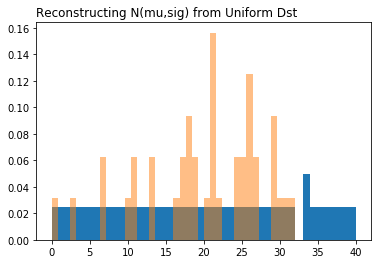

Kl Div = 0.13092265780716683


In [71]:
dst = fake1

lower, upper = np.min(dst), np.max(dst)
mu, sigma = np.mean(dst), np.std(dst)
# s = np.random.truncnorm(mu, sigma, len(dst)) # TODO How many points to sample ?
s = st.truncnorm(a = (lower - mu) / sigma, b = (upper - mu) / sigma, loc=mu, scale=sigma).rvs(len(dst))
s = s.round().astype(int)

bns = int(2 * (mu-lower) + 1)
plt.hist(dst, bins=bns, normed=True);
plt.hist(s, alpha=0.5, bins=bns, normed=True);
plt.title('Reconstructing N(mu,sig) from Uniform Dst',loc='left')
plt.show();
print("Kl Div = {0}".format(my_kl_divergence(dst, s)))

In [75]:
def score_with_normal(dst):
    lower, upper = np.min(dst), np.max(dst)
    mu, sigma = np.mean(dst), np.std(dst)
    # s = np.random.truncnorm(mu, sigma, len(dst)) # TODO How many points to sample ?
    s = st.truncnorm(a = (lower - mu) / sigma, b = (upper - mu) / sigma, loc=mu, scale=sigma).rvs(len(dst))
    s = s.round().astype(int)
    return my_kl_divergence(dst, s)

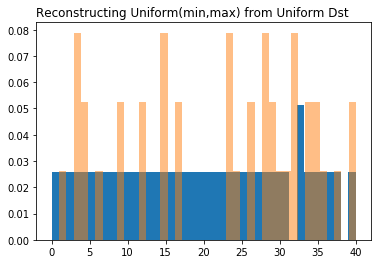

Kl Div = 0.08354695010463606


In [73]:
dst = fake1
    
lower, upper = np.min(dst), np.max(dst)
u = np.random.uniform(lower, upper, len(dst)) # TODO How many points to sample ?
u = u.round().astype(int)

bns = int((upper-lower) + 1)
plt.hist(dst, bins=bns, normed=True);
plt.hist(u, alpha=0.5, bins=bns, normed=True);
plt.title('Reconstructing Uniform(min,max) from Uniform Dst',loc='left')
plt.show();
print("Kl Div = {0}".format(my_kl_divergence(dst, u)))

In [74]:
def score_with_uniform(dst):
    lower, upper = np.min(dst), np.max(dst)
    u = np.random.uniform(lower, upper, len(dst)) # TODO How many points to sample ?
    u = u.round().astype(int)
    return my_kl_divergence(dst, u)